## 1. Article level

In [1]:
#import
import os.path
from gensim import corpora
from gensim.models import LsiModel
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from gensim.models.coherencemodel import CoherenceModel
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import sklearn as s
import dataframe_image as dfi
import networkx as nx
import mantel

C:\ProgramData\Anaconda3\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


### covid-science.txt

In [2]:
def load_data(path,file_name,seperator):
    """
    Input  : path and file_name
    Purpose: loading text file
    Output : list of paragraphs/documents and
             title(initial 100 words considred as title of document)
    """
    documents_list = []
    titles=[]
    document = ''
    i=0
    with open( os.path.join(path, file_name) ,"r", encoding="utf8") as fin:
        data = fin.read()
        words = data.split()
        fin.seek(0)
        print('Number of words in text file :', len(words))
        for line in fin.readlines():
            text = line.strip()
            i=i+1
            if text !='':
                document = document+text
                if text == seperator:
                    documents_list.append(document)
                    document = ''
        documents_list.append(document)
    print("Total Number of Documents:",len(documents_list))
    titles.append( text[0:min(len(text),100)] )
    return documents_list,titles,len(words)

In [3]:
document_list,titles,word_count_science=load_data("","covid-science-15.txt",'NEW_PAPER')

Number of words in text file : 88023
Total Number of Documents: 15


In [4]:
def preprocess_data(doc_set):
    """
    Input  : docuemnt list
    Purpose: preprocess text (tokenize, removing stopwords, and stemming)
    Output : preprocessed text
    """
    # initialize regex tokenizer
    tokenizer = RegexpTokenizer(r'\w+')
    # create English stop words list
    en_stop = set(stopwords.words('english'))
    # Create p_stemmer of class PorterStemmer
    p_stemmer = PorterStemmer()
    # list for tokenized documents in loop
    texts = []
    # loop through document list
    for i in doc_set:
        # clean and tokenize document string
        raw = i.lower()
        tokens = tokenizer.tokenize(raw)
        tokens = [i for i in tokens if len(i)>4]
        print(tokens)
        # remove stop words from tokens
        stopped_tokens = [i for i in tokens if not i in en_stop]
        # stem tokens
        stemmed_tokens = [p_stemmer.stem(i) for i in stopped_tokens]
        # add tokens to list
        texts.append(stemmed_tokens)
    return texts

In [5]:
clean_text=preprocess_data(document_list)

['covidgr', 'dataset', 'covid', 'sdnetmethodology', 'predicting', 'covid', '19based', 'chest', 'imagess', 'tabik', 'gómez', 'martín', 'rodríguez', 'sevillano', 'garcía', 'charte', 'guirado', 'suárez', 'luengo', 'valero', 'gonzález', 'garcía', 'villanova', 'olmedo', 'sánchez', 'herreraabstract', 'currently', 'coronavirus', 'disease', 'covid', 'infectious', 'diseases', 'century', 'diagnosed', 'using', 'testing', 'scans', 'orchest', 'images', 'computed', 'tomography', 'scanners', 'testing', 'available', 'mostmedical', 'centers', 'hence', 'cases', 'imagesbecome', 'effective', 'assisting', 'clinicians', 'making', 'decisions', 'learning', 'neural', 'networkshave', 'great', 'potential', 'building', 'covid', 'triage', 'systemsand', 'detecting', 'covid', 'patients', 'especially', 'patients', 'withlow', 'severity', 'unfortunately', 'current', 'databases', 'allowbuilding', 'systems', 'highly', 'heterogeneousand', 'biased', 'towards', 'severe', 'cases', 'article', 'threefold', 'demystify', 'sensit

In [6]:
def prepare_corpus(doc_clean):
    """
    Input  : clean document
    Purpose: create term dictionary of our courpus and Converting list of documents (corpus) into Document Term Matrix
    Output : term dictionary and Document Term Matrix
    """
    # Creating the term dictionary of our courpus, where every unique term is assigned an index. dictionary = corpora.Dictionary(doc_clean)
    dictionary = corpora.Dictionary(doc_clean)
    # Converting list of documents (corpus) into Document Term Matrix using dictionary prepared above.
    doc_term_matrix = [dictionary.doc2bow(doc) for doc in doc_clean]
    # generate LDA model
    return dictionary,doc_term_matrix

In [7]:
def create_gensim_lsa_model(doc_clean,number_of_topics,words):
    """
    Input  : clean document, number of topics and number of words associated with each topic
    Purpose: create LSA model using gensim
    Output : return LSA model
    """
    dictionary,doc_term_matrix=prepare_corpus(doc_clean)
    # generate LSA model
    lsamodel = LsiModel(doc_term_matrix, num_topics=number_of_topics, id2word = dictionary)  # train model
    #print(lsamodel.print_topics(num_topics=number_of_topics, num_words=words))
    return lsamodel

In [8]:
# LSA Model
number_of_topics=15
words=word_count_science
model_science=create_gensim_lsa_model(clean_text,number_of_topics,words)
words_from_science =dict(model_science.show_topic(0, topn=words))##dict and encoding matrix values

In [9]:
#These variables are for further experimentation in vertical comparission mantel test
model_science_articles = create_gensim_lsa_model(clean_text,number_of_topics,words)

In [10]:
dict(model_science.show_topic(0, topn=5))

{'covid': 0.48404637328080685,
 'imag': 0.34556353402865697,
 'model': 0.29152531367714396,
 'dataset': 0.1920788517016384,
 'class': 0.16833626183973904}

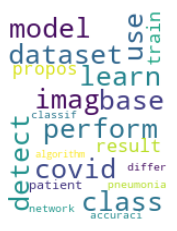

In [11]:
from wordcloud import WordCloud
text = dict(model_science.show_topic(0, topn=20))
l=list(text.keys())
wordcloud = WordCloud(width=150, height=200,max_font_size=25, max_words=20, background_color="white").generate(" ".join(l))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.savefig('graph21.png')

In [12]:
# LSA Model

a=pd.DataFrame()

for i in range(number_of_topics):
    words_science =dict(model_science.show_topic(i, topn=words))
    b=pd.DataFrame(words_science,index=[i])
    a=a.append(b)

a=a.transpose()

top_words = dict(model_science.show_topic(0,topn=5))

df = pd.DataFrame(columns=list(top_words.keys()), 
                  index = list(top_words.keys()))

l = list(top_words.keys())
print('cosine-similarity')
for i in l:
    for j in l:
            matrix=np.array([a.loc[i],a.loc[j]])
            n = s.metrics.pairwise.cosine_similarity(matrix, matrix, dense_output=True)
            df.loc[[i],[j]] = n[0,1]
print(df)

dfi.export(df, 'df_styled24.png')

cosine-similarity
             covid       imag      model    dataset      class
covid            1   0.117954   0.182831 -0.0841955   0.510676
imag      0.117954          1  -0.124147   0.320962  0.0668724
model     0.182831  -0.124147          1 -0.0262809  0.0105534
dataset -0.0841955   0.320962 -0.0262809          1  0.0909586
class     0.510676  0.0668724  0.0105534  0.0909586          1


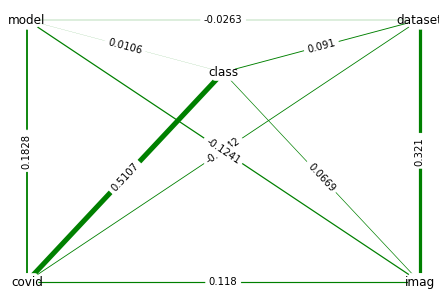

In [13]:
df = df.apply(pd.to_numeric, errors='coerce')

df=df.round(4)

l = list(top_words.keys())

df_adj = pd.DataFrame(df.to_numpy(), index=l, columns=l)
G = nx.from_pandas_adjacency(df)
pos = {l[0]: (0, 0),l[1]: (1, 0), l[2]: (0, 1), l[3]: (1, 1), l[4]: (0.5, 0.8)}
a=list(G.edges(data=True))

b=[]
for i in a:
    b.append(i[:][2]['weight'])
w = [x *10  for x in b]

colors = range(4)
nx.draw(G,pos, alpha=1, width=w, with_labels = True,node_size=200, edge_color='green',node_color='b')
labels = nx.get_edge_attributes(G,'weight')
nx.draw_networkx_nodes(G, pos, nodelist=l, node_color="w")
nx.draw_networkx_edge_labels(G,pos,edge_labels=labels)
plt.rcParams["figure.figsize"] = (8,5)
plt.savefig('fig24.png')

### covid-psychology-large.txt

In [14]:
document_list,titles,word_count_psy=load_data("","covid-psychology-15.txt",'NEW PAPER')

Number of words in text file : 58236
Total Number of Documents: 15


In [15]:
clean_text=preprocess_data(document_list)

['international', 'sociology2021', 'author', '2020article', 'reuse', 'guidelines', 'sagepub', 'journals', 'permissionsdoi', '0268580920948807journals', 'sagepub', 'isspsychology', 'politics', 'ofcovid', 'misinfodemics', 'peoplebelieve', 'misinfodemics', 'sonia', 'mukhtaruniversity', 'management', 'technology', 'lahore', 'pakistanabstractmisinfodemics', 'related', 'covid', 'negatively', 'impacted', 'people', 'lives', 'adversehealth', 'psycho', 'sociopolitical', 'outcomes', 'scientific', 'community', 'seeks', 'communicateevidence', 'based', 'information', 'regarding', 'misplaced', 'preventive', 'strategies', 'misinformed', 'helpseeking', 'behaviors', 'global', 'multifaceted', 'systems', 'secondary', 'emerged', 'effects', 'ofmisinfodemics', 'public', 'published', 'articles', 'pubmed', 'embase', 'google', 'scholar', 'elsevierabout', 'covid', 'related', 'misinfodemics', 'considered', 'reviewed', 'article', 'thisreview', 'examines', 'mechanisms', 'operational', 'structure', 'prevalence', 'pr

In [16]:
# LSA Model
number_of_topics=15
words=word_count_psy
model_psy=create_gensim_lsa_model(clean_text,number_of_topics,words)
words_from_psychology =dict(model_psy.show_topic(0, topn=words))#dict and encoding matrix values


In [17]:
#These variables are for further experimentation in vertical comparission mantel test
model_psy_articles=create_gensim_lsa_model(clean_text,number_of_topics,words)

In [18]:
dict(model_psy.show_topic(0,topn=5))

{'covid': 0.4241833010171727,
 'psycholog': 0.276494658493425,
 'group': 0.25392735028600955,
 'pandem': 0.22421308419475472,
 'health': 0.2080533594503455}

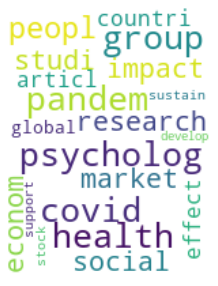

In [19]:
from wordcloud import WordCloud
text = dict(model_psy.show_topic(0, topn=20))
l=list(text.keys())
wordcloud = WordCloud(width=150, height=200,max_font_size=25, max_words=20, background_color="white").generate(" ".join(l))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.savefig('graph22.png')

In [20]:
# LSA Model

a=pd.DataFrame()

for i in range(number_of_topics):
    words_psy =dict(model_psy.show_topic(i, topn=words))
    b=pd.DataFrame(words_psy,index=[i])
    a=a.append(b)

a=a.transpose()

top_words = dict(model_psy.show_topic(0,topn=5))

df = pd.DataFrame(columns=list(top_words.keys()), 
                  index = list(top_words.keys()))

l = list(top_words.keys())
print('cosine-similarity')
for i in l:
    for j in l:
            matrix=np.array([a.loc[i],a.loc[j]])
            n = s.metrics.pairwise.cosine_similarity(matrix, matrix, dense_output=True)
            df.loc[[i],[j]] = n[0,1]
print(df)

dfi.export(df, 'df_styled25.png')

cosine-similarity
              covid   psycholog       group     pandem     health
covid             1    0.235744    0.032874    0.48363    0.12375
psycholog  0.235744           1  0.00600425   0.355838   0.359423
group      0.032874  0.00600425           1 -0.0361535 -0.0297868
pandem      0.48363    0.355838  -0.0361535          1   0.466249
health      0.12375    0.359423  -0.0297868   0.466249          1


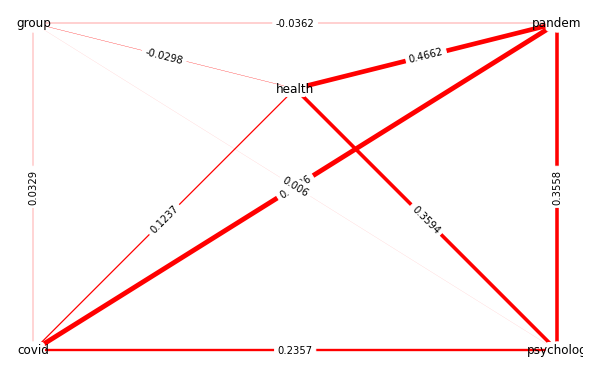

In [21]:
df = df.apply(pd.to_numeric, errors='coerce')

df=df.round(4)

l = list(top_words.keys())

df_adj = pd.DataFrame(df.to_numpy(), index=l, columns=l)
G = nx.from_pandas_adjacency(df)
pos = {l[0]: (0, 0),l[1]: (1, 0), l[2]: (0, 1), l[3]: (1, 1), l[4]: (0.5, 0.8)}
a=list(G.edges(data=True))

b=[]
for i in a:
    b.append(i[:][2]['weight'])
w = [x *10  for x in b]

colors = range(4)
nx.draw(G,pos, alpha=1, width=w, with_labels = True,node_size=200, edge_color='r',node_color='b')
labels = nx.get_edge_attributes(G,'weight')
nx.draw_networkx_nodes(G, pos, nodelist=l, node_color="w")
nx.draw_networkx_edge_labels(G,pos,edge_labels=labels)
plt.rcParams["figure.figsize"] = (8,5)
plt.savefig('fig25.png')

In [22]:
def mantel_test(n):
    words_science = dict(model_science.show_topic(0, topn=word_count_science))
    words_psy = dict(model_psy.show_topic(0, topn=word_count_psy))

    top_words_science = dict(model_science.show_topic(0, topn=n)) 
    top_words_psy = dict(model_psy.show_topic(0,topn=n)) 


    c={} #law words in non law
    for key in top_words_science:
        try:
            c[key] = words_psy[key]
        except KeyError:
            c[key] = 0

    top_words_psy.update(c)

    b={} #non law words in law
    for key in top_words_psy:
        try:
            b[key] = words_science[key]
        except KeyError:
            b[key] = 0

    b.update(top_words_science)
    top_words_science=b

    #pairwise distance for law
    a=pd.DataFrame()

    for i in range(number_of_topics):
        words_from_science =dict(model_science.show_topic(i, topn=word_count_science))
        b=pd.DataFrame(words_from_science,index=[i])
        a=a.append(b)

    a=a.transpose()

    df = pd.DataFrame(columns=list(top_words_science.keys()), 
                      index = list(top_words_science.keys()))

    l = list(top_words_science.keys())

    print('Pairwise-distance')
    for i in l:
        for j in l:
            try:
                matrix=np.array([a.loc[i],a.loc[j]])
            except KeyError:
                matrix=np.zeros((2,3))
            n = s.metrics.pairwise.nan_euclidean_distances(matrix, matrix)
            df.loc[[i],[j]] = n[0,1]
    print(df)
    df1 = df.to_numpy()
    #pairwise distace for non-law
    a=pd.DataFrame()

    for i in range(number_of_topics):
        words_from_psy =dict(model_psy.show_topic(i, topn=word_count_psy))
        b=pd.DataFrame(words_from_psy,index=[i])
        a=a.append(b)

    a=a.transpose()

    df = pd.DataFrame(columns=list(top_words_psy.keys()), 
                      index = list(top_words_psy.keys()))

    l = list(top_words_psy.keys())
    print('Pairwise-distance')
    for i in l:
        for j in l:
            try:
                matrix=np.array([a.loc[i],a.loc[j]])
            except KeyError:
                matrix=np.zeros((2,3))
            n = s.metrics.pairwise.nan_euclidean_distances(matrix, matrix)
            df.loc[[i],[j]] = n[0,1]
    print(df)
    df2 = df.to_numpy()
    

    dist1 = list(df1[np.triu_indices(len(top_words_science), k = 1)])

    

    dist2 = list(df2[np.triu_indices(len(top_words_psy), k = 1)])

    return mantel.test(dist1, dist2, perms=10000, method='pearson', tail='upper')

In [23]:
mantel_test(5)

Pairwise-distance
              covid    psycholog     group    pandem    health      imag  \
covid             0     0.627345  0.616418  0.634626  0.599659  0.906064   
psycholog  0.627345  1.16415e-10  0.066445  0.196729  0.149188  0.731796   
group      0.616418     0.066445         0  0.200285  0.161369  0.717135   
pandem     0.634626     0.196729  0.200285         0  0.198709  0.785046   
health     0.599659     0.149188  0.161369  0.198709         0  0.762977   
imag       0.906064     0.731796  0.717135  0.785046  0.762977         0   
model       0.83963     0.684718    0.7009   0.68419  0.696724   1.06205   
dataset    0.901475     0.596784  0.616381  0.636306  0.612924  0.781713   
class      0.560897      0.47378  0.504815  0.554316  0.498453  0.844705   

              model   dataset     class  
covid       0.83963  0.901475  0.560897  
psycholog  0.684718  0.596784   0.47378  
group        0.7009  0.616381  0.504815  
pandem      0.68419  0.636306  0.554316  
health     

(-0.5583274383531106, 0.9722, -1.7668867248811133)

In [24]:
mantel_test(10)

Pairwise-distance
              covid    psycholog      group    pandem     health        peopl  \
covid             0     0.627345   0.616418  0.634626   0.599659     0.661675   
psycholog  0.627345  1.16415e-10   0.066445  0.196729   0.149188     0.293753   
group      0.616418     0.066445          0  0.200285   0.161369     0.298513   
pandem     0.634626     0.196729   0.200285         0   0.198709     0.326716   
health     0.599659     0.149188   0.161369  0.198709          0     0.330524   
peopl      0.661675     0.293753   0.298513  0.326716   0.330524  7.45058e-09   
impact      0.61597       0.0638  0.0972342  0.222891   0.142905     0.289812   
social     0.737109     0.430898   0.420895   0.40153   0.430305     0.394205   
studi      0.586486     0.164695   0.161258  0.247848   0.187599     0.313501   
research   0.595436    0.0901519   0.120434  0.201167  0.0975713     0.322663   
imag       0.906064     0.731796   0.717135  0.785046   0.762977     0.835098   
model     

(-0.4187028966996108, 0.9848, -1.9122287293861753)

## 2. 2-3 paragraphs

### covid-science.txt

In [25]:
def load_data(path,file_name):
    """
    Input  : path and file_name
    Purpose: loading text file
    Output : list of paragraphs/documents and
             title(initial 100 words considred as title of document)
    """
    documents_list = []
    titles=[]
    document = ''
    i=0
    with open( os.path.join(path, file_name) ,"r",encoding="utf8") as fin:
        data = fin.read()
        words = data.split()
        fin.seek(0)
        print('Number of words in text file :', len(words))
        for word in words:
                i=i+1
                document = document+word+' '
                if i == 200:
                    documents_list.append(document)
                    document,i = '',0
                    if len(documents_list) == 2:
                        break
    print("Total Number of Documents:",len(documents_list))
    #titles.append( text[0:min(len(text),100)] )
    return documents_list,titles,len(words)

In [26]:
document_list,titles,word_count_science=load_data("","covid-science-15.txt")

Number of words in text file : 88023
Total Number of Documents: 2


In [27]:
clean_text=preprocess_data(document_list)

['covidgr', 'dataset', 'covid', 'sdnet', 'methodology', 'predicting', 'covid', 'based', 'chest', 'images', 'tabik', 'gómez', 'martín', 'rodríguez', 'sevillano', 'garcía', 'charte', 'guirado', 'suárez', 'luengo', 'valero', 'gonzález', 'garcía', 'villanova', 'olmedo', 'sánchez', 'herrera', 'abstract', 'currently', 'coronavirus', 'disease', 'covid', 'infectious', 'diseases', 'century', 'diagnosed', 'using', 'testing', 'scans', 'chest', 'images', 'computed', 'tomography', 'scanners', 'testing', 'available', 'medical', 'centers', 'hence', 'cases', 'images', 'become', 'effective', 'assisting', 'clinicians', 'making', 'decisions', 'learning', 'neural', 'networks', 'great', 'potential', 'building', 'covid', 'triage', 'systems', 'detecting', 'covid', 'patients', 'especially', 'patients', 'severity', 'unfortunately', 'current', 'databases', 'allow', 'building', 'systems', 'highly', 'heterogeneous', 'biased', 'towards', 'severe', 'cases', 'article', 'threefold', 'demystify', 'sensitivities', 'ach

In [28]:
# LSA Model
number_of_topics=2
words_nscience=len(clean_text[0])+len(clean_text[1])
model_science=create_gensim_lsa_model(clean_text,number_of_topics,words_nscience)
words_science =dict(model_science.show_topic(0, topn=words))##dict and encoding matrix values

In [29]:
#These variables are for further experimentation in vertical comparission mantel test
model_science_p=create_gensim_lsa_model(clean_text,number_of_topics,words_nscience)

In [30]:
words_nscience

238

In [31]:
dict(model_science.show_topic(0, topn=5))

{'support': -0.3289947178827894,
 'granada': -0.24814037209037276,
 'covid': -0.22769581399154298,
 'programm': -0.2193298119218596,
 'research': -0.2193298119218596}

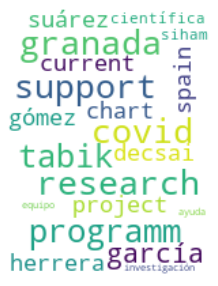

In [32]:
from wordcloud import WordCloud
text = dict(model_science.show_topic(0, topn=20))
l=list(text.keys())
wordcloud = WordCloud(width=150, height=200,max_font_size=25, max_words=20, background_color="white").generate(" ".join(l))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.savefig('graph23.png')

In [33]:
# LSA Model

a=pd.DataFrame()

for i in range(number_of_topics):
    words_science =dict(model_science.show_topic(i, topn = words_nscience))
    b=pd.DataFrame(words_science,index=[i])
    a=a.append(b)

a=a.transpose()

top_words = dict(model_science.show_topic(0,topn=5))

df = pd.DataFrame(columns=list(top_words.keys()), 
                  index = list(top_words.keys()))

l = list(top_words.keys())
print('cosine-similarity')
for i in l:
    for j in l:
            matrix=np.array([a.loc[i],a.loc[j]])
            n = s.metrics.pairwise.cosine_similarity(matrix, matrix, dense_output=True)
            df.loc[[i],[j]] = n[0,1]
print(df)

dfi.export(df, 'df_styled26.png')

cosine-similarity
            support   granada      covid   programm   research
support           1  0.956969 -0.0794645          1          1
granada    0.956969         1   0.213226   0.956969   0.956969
covid    -0.0794645  0.213226          1 -0.0794645 -0.0794645
programm          1  0.956969 -0.0794645          1          1
research          1  0.956969 -0.0794645          1          1


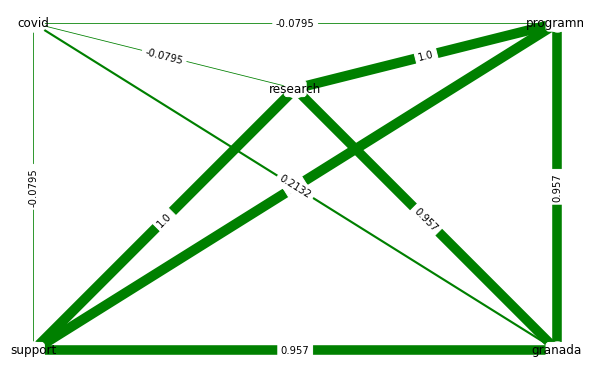

In [34]:
df = df.apply(pd.to_numeric, errors='coerce')

df=df.round(4)

l = list(top_words.keys())

df_adj = pd.DataFrame(df.to_numpy(), index=l, columns=l)
G = nx.from_pandas_adjacency(df)
pos = {l[0]: (0, 0),l[1]: (1, 0), l[2]: (0, 1), l[3]: (1, 1), l[4]: (0.5, 0.8)}
a=list(G.edges(data=True))

b=[]
for i in a:
    b.append(i[:][2]['weight'])
w = [x *10  for x in b]

colors = range(4)
nx.draw(G,pos, alpha=1, width=w, with_labels = True,node_size=200, edge_color='green',node_color='b')
labels = nx.get_edge_attributes(G,'weight')
nx.draw_networkx_nodes(G, pos, nodelist=l, node_color="w")
nx.draw_networkx_edge_labels(G,pos,edge_labels=labels)
plt.rcParams["figure.figsize"] = (8,5)
plt.savefig('fig26.png')

### covid-psycology.txt

In [35]:
document_list,titles,word_count_psy=load_data("","covid-psychology-15.txt")

Number of words in text file : 58236
Total Number of Documents: 2


In [36]:
clean_text=preprocess_data(document_list)

['international', 'sociology', 'author', 'article', 'reuse', 'guidelines', 'sagepub', 'journals', 'permissions', '0268580920948807', 'journals', 'sagepub', 'psychology', 'politics', 'covid', 'misinfodemics', 'people', 'believe', 'misinfodemics', 'sonia', 'mukhtar', 'university', 'management', 'technology', 'lahore', 'pakistan', 'abstract', 'misinfodemics', 'related', 'covid', 'negatively', 'impacted', 'people', 'lives', 'adverse', 'health', 'psycho', 'sociopolitical', 'outcomes', 'scientific', 'community', 'seeks', 'communicate', 'evidence', 'based', 'information', 'regarding', 'misplaced', 'preventive', 'strategies', 'misinformed', 'helpseeking', 'behaviors', 'global', 'multifaceted', 'systems', 'secondary', 'emerged', 'effects', 'misinfodemics', 'public', 'published', 'articles', 'pubmed', 'embase', 'google', 'scholar', 'elsevier', 'about', 'covid', 'related', 'misinfodemics', 'considered', 'reviewed', 'article', 'review', 'examines', 'mechanisms', 'operational', 'structure', 'preval

In [37]:
# LSA Model
number_of_topics=2
words_npsy=len(clean_text[0])+len(clean_text[1])
model_psy=create_gensim_lsa_model(clean_text,number_of_topics,words_npsy)
words_from_psychology =dict(model_psy.show_topic(0, topn=words))##dict and encoding matrix values

In [38]:
#These variables are for further experimentation in vertical comparission mantel test
model_psy_p = create_gensim_lsa_model(clean_text,number_of_topics,words_npsy)

In [39]:
dict(model_psy.show_topic(0, topn=5))

{'misinfodem': 0.5033743541941376,
 'covid': 0.3629711503323517,
 'articl': 0.21459251935197443,
 'commun': 0.14837863098037718,
 'mechan': 0.1483786309803767}

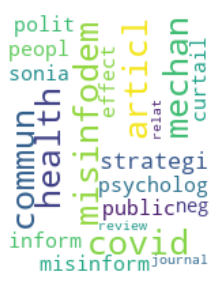

In [40]:
from wordcloud import WordCloud
text = dict(model_psy.show_topic(0, topn=20))
l=list(text.keys())
wordcloud = WordCloud(width=150, height=200,max_font_size=25, max_words=20, background_color="white").generate(" ".join(l))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.savefig('graph24.png')

In [41]:
# LSA Model

a=pd.DataFrame()

for i in range(number_of_topics):
    words_psy =dict(model_psy.show_topic(i, topn=words_npsy))
    b=pd.DataFrame(words_psy,index=[i])
    a=a.append(b)

a=a.transpose()

top_words = dict(model_psy.show_topic(0,topn=5))

df = pd.DataFrame(columns=list(top_words.keys()), 
                  index = list(top_words.keys()))

l = list(top_words.keys())
print('cosine-similarity')
for i in l:
    for j in l:
            matrix=np.array([a.loc[i],a.loc[j]])
            n = s.metrics.pairwise.cosine_similarity(matrix, matrix, dense_output=True)
            df.loc[[i],[j]] = n[0,1]
print(df)

dfi.export(df, 'df_styled27.png')

cosine-similarity
           misinfodem     covid    articl    commun    mechan
misinfodem          1  0.976353  0.993795  0.755596  0.755596
covid        0.976353         1  0.946251  0.879335  0.879335
articl       0.993795  0.946251         1  0.678051  0.678051
commun       0.755596  0.879335  0.678051         1         1
mechan       0.755596  0.879335  0.678051         1         1


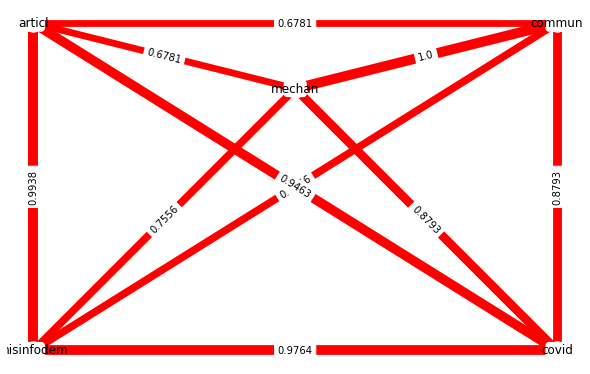

In [42]:
df = df.apply(pd.to_numeric, errors='coerce')

df=df.round(4)

l = list(top_words.keys())

df_adj = pd.DataFrame(df.to_numpy(), index=l, columns=l)
G = nx.from_pandas_adjacency(df)
pos = {l[0]: (0, 0),l[1]: (1, 0), l[2]: (0, 1), l[3]: (1, 1), l[4]: (0.5, 0.8)}
a=list(G.edges(data=True))

b=[]
for i in a:
    b.append(i[:][2]['weight'])
w = [x *10  for x in b]

colors = range(4)
nx.draw(G,pos, alpha=1, width=w, with_labels = True,node_size=200, edge_color='r',node_color='b')
labels = nx.get_edge_attributes(G,'weight')
nx.draw_networkx_nodes(G, pos, nodelist=l, node_color="w")
nx.draw_networkx_edge_labels(G,pos,edge_labels=labels)
plt.rcParams["figure.figsize"] = (8,5)
plt.savefig('fig27.png')

In [43]:
mantel_test(5)

Pairwise-distance
           misinfodem     covid    articl commun mechan   support    granada  \
misinfodem          0         0         0      0      0         0          0   
covid               0         0  0.378443      0      0  0.628979    0.47364   
articl              0  0.378443         0      0      0  0.423546   0.266413   
commun              0         0         0      0      0         0          0   
mechan              0         0         0      0      0         0          0   
support             0  0.628979  0.423546      0      0         0   0.168269   
granada             0   0.47364  0.266413      0      0  0.168269          0   
programm            0  0.545218  0.293443      0      0  0.133207  0.0775087   
research            0  0.545218  0.293443      0      0  0.133207  0.0775087   

             programm   research  
misinfodem          0          0  
covid        0.545218   0.545218  
articl       0.293443   0.293443  
commun              0          0  
mechan

(-0.12443276806076488, 0.6549, -0.511434675696413)

In [44]:
mantel_test(10)

Pairwise-distance
           misinfodem     covid    articl commun mechan health strategi  \
misinfodem          0         0         0      0      0      0        0   
covid               0         0  0.378443      0      0      0        0   
articl              0  0.378443         0      0      0      0        0   
commun              0         0         0      0      0      0        0   
mechan              0         0         0      0      0      0        0   
health              0         0         0      0      0      0        0   
strategi            0         0         0      0      0      0        0   
psycholog           0         0         0      0      0      0        0   
misinform           0         0         0      0      0      0        0   
public              0  0.465052  0.112805      0      0      0        0   
support             0  0.628979  0.423546      0      0      0        0   
granada             0   0.47364  0.266413      0      0      0        0   
program

(-0.15851516925283998, 0.8535, -1.0488047694214804)

## Paragraph level

### covid-science.txt

In [45]:
def load_data(path,file_name):
    """
    Input  : path and file_name
    Purpose: loading text file
    Output : list of paragraphs/documents and
             title(initial 100 words considred as title of document)
    """
    documents_list = []
    titles=[]
    with open( os.path.join(path, file_name) ,"r",encoding='UTF8') as fin:
        data = fin.read()
        words = data.split()
        fin.seek(0)
        print('Number of words in text file :', len(words))
        for line in fin.readlines():
            text = line.strip()
            if text !='':
                documents_list.append(text)
    print("Total Number of Documents:",len(documents_list))
    titles.append( text[0:min(len(text),100)] )
    return documents_list,titles,len(words)

In [46]:
document_list,titles,word_count_science=load_data("","covid-science-15.txt")

Number of words in text file : 88023
Total Number of Documents: 10436


In [47]:
clean_text=preprocess_data(document_list)

['covidgr', 'dataset', 'covid', 'sdnet']
['methodology', 'predicting', 'covid']
['based', 'chest', 'images']
['tabik', 'gómez', 'martín', 'rodríguez', 'sevillano', 'garcía', 'charte']
['guirado', 'suárez', 'luengo', 'valero', 'gonzález', 'garcía', 'villanova']
['olmedo', 'sánchez', 'herrera']
['abstract', 'currently', 'coronavirus', 'disease', 'covid']
['infectious', 'diseases', 'century', 'diagnosed', 'using', 'testing', 'scans']
['chest', 'images', 'computed', 'tomography']
['scanners', 'testing', 'available']
['medical', 'centers', 'hence', 'cases', 'images']
['become', 'effective', 'assisting', 'clinicians', 'making', 'decisions', 'learning', 'neural', 'networks']
['great', 'potential', 'building', 'covid', 'triage', 'systems']
['detecting', 'covid', 'patients', 'especially', 'patients']
['severity', 'unfortunately', 'current', 'databases', 'allow']
['building', 'systems', 'highly', 'heterogeneous']
['biased', 'towards', 'severe', 'cases', 'article', 'threefold', 'demystify', 'sens

In [48]:
# LSA Model
number_of_topics=100
words=word_count_science
model_science=create_gensim_lsa_model(clean_text,number_of_topics,words)
words_from_law =dict(model_science.show_topic(0, topn=words))##dict and encoding matrix values

In [49]:
#These variables are for further experimentation in vertical comparission mantel test
model_science_paragraph=create_gensim_lsa_model(clean_text,number_of_topics,words)

In [50]:
dict(model_science.show_topic(0, topn=5))

{'covid': 0.8173316479466738,
 'imag': 0.32835719547350367,
 'model': 0.19244766283134151,
 'detect': 0.1700824506894798,
 'dataset': 0.13468398563227243}

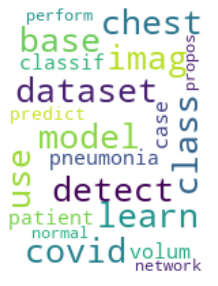

In [51]:
from wordcloud import WordCloud
text = dict(model_science.show_topic(0, topn=20))
l=list(text.keys())
wordcloud = WordCloud(width=150, height=200,max_font_size=25, max_words=20, background_color="white").generate(" ".join(l))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.savefig('graph25.png')

In [52]:
# LSA Model

a=pd.DataFrame()

for i in range(number_of_topics):
    words_science =dict(model_science.show_topic(i, topn=words))
    b=pd.DataFrame(words_science,index=[i])
    a=a.append(b)

a=a.transpose()

top_words = dict(model_science.show_topic(0,topn=5))

df = pd.DataFrame(columns=list(top_words.keys()), 
                  index = list(top_words.keys()))

l = list(top_words.keys())
print('cosine-similarity')
for i in l:
    for j in l:
            matrix=np.array([a.loc[i],a.loc[j]])
            n = s.metrics.pairwise.cosine_similarity(matrix, matrix, dense_output=True)
            df.loc[[i],[j]] = n[0,1]
print(df)

dfi.export(df, 'df_styled28.png')

cosine-similarity
               covid         imag        model       detect      dataset
covid              1   0.00123781  0.000365384   0.00800962  0.000934745
imag      0.00123781            1  0.000764231  -0.00799469  -0.00232223
model    0.000365384  0.000764231            1   0.00280805 -0.000605737
detect    0.00800962  -0.00799469   0.00280805            1  0.000416076
dataset  0.000934745  -0.00232223 -0.000605737  0.000416076            1


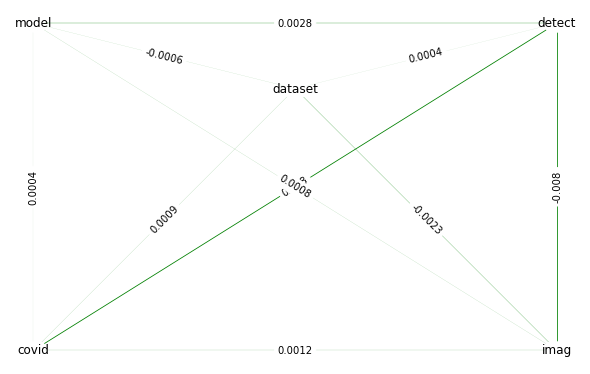

In [53]:
df = df.apply(pd.to_numeric, errors='coerce')

df=df.round(4)

l = list(top_words.keys())

df_adj = pd.DataFrame(df.to_numpy(), index=l, columns=l)
G = nx.from_pandas_adjacency(df)
pos = {l[0]: (0, 0),l[1]: (1, 0), l[2]: (0, 1), l[3]: (1, 1), l[4]: (0.5, 0.8)}
a=list(G.edges(data=True))

b=[]
for i in a:
    b.append(i[:][2]['weight'])
w = [x *100  for x in b]

colors = range(4)
nx.draw(G,pos, alpha=1, width=w, with_labels = True,node_size=200, edge_color='green',node_color='b')
labels = nx.get_edge_attributes(G,'weight')
nx.draw_networkx_nodes(G, pos, nodelist=l, node_color="w")
nx.draw_networkx_edge_labels(G,pos,edge_labels=labels)
plt.rcParams["figure.figsize"] = (8,5)
plt.savefig('fig28.png')

### covid-psychology-large.txt

In [54]:
document_list,titles,word_count_psy=load_data("","covid-psychology-15.txt")

Number of words in text file : 58236
Total Number of Documents: 6353


In [55]:
clean_text=preprocess_data(document_list)

['international', 'sociology']
[]
['author']
['article', 'reuse', 'guidelines']
['sagepub', 'journals', 'permissions']
['0268580920948807']
['journals', 'sagepub']
['psychology', 'politics']
['covid', 'misinfodemics']
['people']
['believe', 'misinfodemics']
['sonia', 'mukhtar']
['university', 'management', 'technology', 'lahore', 'pakistan']
['abstract']
['misinfodemics', 'related', 'covid', 'negatively', 'impacted', 'people', 'lives', 'adverse']
['health', 'psycho', 'sociopolitical', 'outcomes', 'scientific', 'community', 'seeks', 'communicate']
['evidence', 'based', 'information', 'regarding', 'misplaced', 'preventive', 'strategies', 'misinformed', 'helpseeking', 'behaviors', 'global', 'multifaceted', 'systems', 'secondary', 'emerged', 'effects']
['misinfodemics', 'public', 'published', 'articles', 'pubmed', 'embase', 'google', 'scholar', 'elsevier']
['about', 'covid', 'related', 'misinfodemics', 'considered', 'reviewed', 'article']
['review', 'examines', 'mechanisms', 'operational',

In [56]:
# LSA Model
number_of_topics=100
words=word_count_psy
model_psy=create_gensim_lsa_model(clean_text,number_of_topics,words)
words_from_psychology =dict(model_psy.show_topic(0, topn=words))##dict and encoding matrix values

In [57]:
#These variables are for further experimentation in vertical comparission mantel test
model_psy_paragraph=create_gensim_lsa_model(clean_text,number_of_topics,words)

In [58]:
dict(model_psy.show_topic(0, topn=5))

{'covid': 0.3665193827288808,
 'pandem': 0.36094244989669616,
 'health': 0.3248658297265896,
 'polici': 0.29428572192418073,
 'impact': 0.23191430022007598}

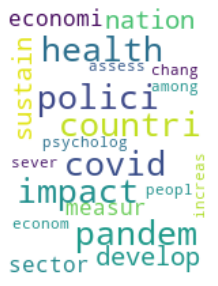

In [59]:
from wordcloud import WordCloud
text = dict(model_psy.show_topic(0, topn=20))
l=list(text.keys())
wordcloud = WordCloud(width=150, height=200,max_font_size=25, max_words=20, background_color="white").generate(" ".join(l))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.savefig('graph26.png')

In [60]:
# LSA Model

a=pd.DataFrame()

for i in range(number_of_topics):
    words_psy =dict(model_psy.show_topic(i, topn=words))
    b=pd.DataFrame(words_psy,index=[i])
    a=a.append(b)

a=a.transpose()

top_words = dict(model_psy.show_topic(0,topn=5))

df = pd.DataFrame(columns=list(top_words.keys()), 
                  index = list(top_words.keys()))

l = list(top_words.keys())
print('cosine-similarity')
for i in l:
    for j in l:
            matrix=np.array([a.loc[i],a.loc[j]])
            n = s.metrics.pairwise.cosine_similarity(matrix, matrix, dense_output=True)
            df.loc[[i],[j]] = n[0,1]
print(df)

dfi.export(df, 'df_styled29.png')

cosine-similarity
              covid       pandem       health       polici       impact
covid             1 -0.000251484  -0.00102935   0.00200395   0.00491427
pandem -0.000251484            1  -0.00206637 -0.000776059   0.00266831
health  -0.00102935  -0.00206637            1   0.00450039  0.000610171
polici   0.00200395 -0.000776059   0.00450039            1  -0.00567595
impact   0.00491427   0.00266831  0.000610171  -0.00567595            1


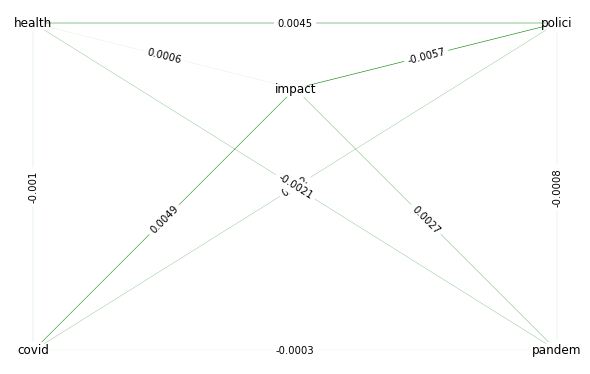

In [61]:
df = df.apply(pd.to_numeric, errors='coerce')

df=df.round(4)

l = list(top_words.keys())

df_adj = pd.DataFrame(df.to_numpy(), index=l, columns=l)
G = nx.from_pandas_adjacency(df)
pos = {l[0]: (0, 0),l[1]: (1, 0), l[2]: (0, 1), l[3]: (1, 1), l[4]: (0.5, 0.8)}
a=list(G.edges(data=True))

b=[]
for i in a:
    b.append(i[:][2]['weight'])
w = [x *100  for x in b]

colors = range(4)
nx.draw(G,pos, alpha=1, width=w, with_labels = True,node_size=200, edge_color='g',node_color='b')
labels = nx.get_edge_attributes(G,'weight')
nx.draw_networkx_nodes(G, pos, nodelist=l, node_color="w")
nx.draw_networkx_edge_labels(G,pos,edge_labels=labels)
plt.rcParams["figure.figsize"] = (8,5)
plt.savefig('fig29.png')

In [62]:
mantel_test(5)

Pairwise-distance
               covid    pandem    health    polici    impact      imag  \
covid    2.10734e-08   1.29174   1.34614  0.996639  0.997331   1.40455   
pandem       1.29174         0   1.22761  0.831439  0.863993   1.30309   
health       1.34614   1.22761         0   0.89882  0.846913   1.34228   
polici      0.996639  0.831439   0.89882         0  0.130483  0.994958   
impact      0.997331  0.863993  0.846913  0.130483         0   1.00193   
imag         1.40455   1.30309   1.34228  0.994958   1.00193         0   
model        1.40535   1.30616   1.34301  0.994937   1.00125   1.40434   
detect       1.37031   1.27076   1.30048  0.953255   0.95357   1.38056   
dataset       1.4048   1.30695   1.34452  0.994289   1.00036   1.40636   

            model       detect   dataset  
covid     1.40535      1.37031    1.4048  
pandem    1.30616      1.27076   1.30695  
health    1.34301      1.30048   1.34452  
polici   0.994937     0.953255  0.994289  
impact    1.00125      0.9

(-0.36722959799295146, 0.8156, -1.0916996508045393)

In [63]:
mantel_test(10)

Pairwise-distance
               covid    pandem    health     polici    impact      countri  \
covid    2.10734e-08   1.29174   1.34614   0.996639  0.997331       1.0006   
pandem       1.29174         0   1.22761   0.831439  0.863993       0.8195   
health       1.34614   1.22761         0    0.89882  0.846913     0.909924   
polici      0.996639  0.831439   0.89882          0  0.130483    0.0886125   
impact      0.997331  0.863993  0.846913   0.130483         0     0.158511   
countri       1.0006    0.8195  0.909924  0.0886125  0.158511  2.63418e-09   
develop      1.01972  0.836573  0.945239   0.219142  0.258953     0.198135   
nation       1.05631  0.956099  0.890934   0.351072  0.338373     0.367674   
sustain     0.994409  0.845449  0.903259   0.042095  0.121871    0.0918988   
economi     0.995097  0.834319  0.891971  0.0466139  0.115609    0.0887288   
imag         1.40455   1.30309   1.34228   0.994958   1.00193      1.00063   
model        1.40535   1.30616   1.34301   0.9

(-0.4775879754844936, 0.9934, -2.174520016647468)

In [64]:
def mantel_test_verticle(model_a,model_b,n):
    words_science = dict(model_a.show_topic(0, topn=word_count_science))
    words_psy = dict(model_b.show_topic(0, topn=word_count_psy))

    top_words_science = dict(model_a.show_topic(0, topn=n)) 
    top_words_psy = dict(model_b.show_topic(0,topn=n)) 


    c={} #law words in non law
    for key in top_words_science:
        try:
            c[key] = words_psy[key]
        except KeyError:
            c[key] = 0

    top_words_psy.update(c)

    b={} #non law words in law
    for key in top_words_psy:
        try:
            b[key] = words_science[key]
        except KeyError:
            b[key] = 0

    b.update(top_words_science)
    top_words_science=b

    #pairwise distance for law
    a=pd.DataFrame()

    for i in range(number_of_topics):
        words_from_science =dict(model_a.show_topic(i, topn=word_count_science))
        b=pd.DataFrame(words_from_science,index=[i])
        a=a.append(b)

    a=a.transpose()

    df = pd.DataFrame(columns=list(top_words_science.keys()), 
                      index = list(top_words_science.keys()))

    l = list(top_words_science.keys())

    print('Pairwise-distance')
    for i in l:
        for j in l:
            try:
                matrix=np.array([a.loc[i],a.loc[j]])
            except KeyError:
                matrix=np.zeros((2,3))
            n = s.metrics.pairwise.nan_euclidean_distances(matrix, matrix)
            df.loc[[i],[j]] = n[0,1]
    print(df)
    df1 = df.to_numpy()
    #pairwise distace for non-law
    a=pd.DataFrame()

    for i in range(number_of_topics):
        words_from_psy =dict(model_b.show_topic(i, topn=word_count_psy))
        b=pd.DataFrame(words_from_psy,index=[i])
        a=a.append(b)

    a=a.transpose()

    df = pd.DataFrame(columns=list(top_words_psy.keys()), 
                      index = list(top_words_psy.keys()))

    l = list(top_words_psy.keys())
    print('Pairwise-distance')
    for i in l:
        for j in l:
            try:
                matrix=np.array([a.loc[i],a.loc[j]])
            except KeyError:
                matrix=np.zeros((2,3))
            n = s.metrics.pairwise.nan_euclidean_distances(matrix, matrix)
            df.loc[[i],[j]] = n[0,1]
    print(df)
    df2 = df.to_numpy()
    

    dist1 = list(df1[np.triu_indices(len(top_words_science), k = 1)])

    

    dist2 = list(df2[np.triu_indices(len(top_words_psy), k = 1)])

    return mantel.test(dist1, dist2, perms=10000, method='pearson', tail='upper')

In [65]:
mantel_test_verticle(model_science_articles,model_science_p,5)

Pairwise-distance
           support    granada    covid     programm     research     imag  \
support          0   0.168942  1.53014     0.161791      0.26492  1.91808   
granada   0.168942          0  1.59104    0.0865721     0.263193  1.90158   
covid      1.53014    1.59104        0      1.60946      1.53741  2.33945   
programm  0.161791  0.0865721  1.60946  8.50177e-10     0.236021  1.89246   
research   0.26492   0.263193  1.53741     0.236021  4.80933e-09  1.88855   
imag       1.91808    1.90158  2.33945      1.89246      1.88855        0   
model      1.80501    1.77285  2.16792      1.76767      1.78488   2.7422   
dataset    1.52842    1.52151   2.3276      1.53273      1.53878  2.01837   
class       1.1637     1.1496  1.44823       1.1976      1.20895  2.18102   

                model  dataset    class  
support       1.80501  1.52842   1.1637  
granada       1.77285  1.52151   1.1496  
covid         2.16792   2.3276  1.44823  
programm      1.76767  1.53273   1.1976  
r

(0.27763795369161115, 0.1765, 1.062241885835958)

In [66]:
mantel_test_verticle(model_science_articles,model_science_paragraph,5)

Pairwise-distance
           covid     imag        model   detect  dataset    class
covid          0  2.33945      2.16792  1.61978   2.3276  1.44823
imag     2.33945        0       2.7422  1.75983  2.01837  2.18102
model    2.16792   2.7422  2.72057e-08  1.68726  2.37406  2.13815
detect   1.61978  1.75983      1.68726        0  1.79884  1.49212
dataset   2.3276  2.01837      2.37406  1.79884        0  1.87763
class    1.44823  2.18102      2.13815  1.49212  1.87763        0
Pairwise-distance
           covid         imag    model   detect      dataset        class
covid          0      1.40496  1.40555   1.3692       1.4051      1.40077
imag     1.40496  2.10734e-08  1.40438  1.37789      1.40624      1.40121
model    1.40555      1.40438        0  1.37233      1.40535      1.40127
detect    1.3692      1.37789  1.37233        0      1.37291       1.3683
dataset   1.4051      1.40624  1.40535  1.37291  2.58096e-08      1.40167
class    1.40077      1.40121  1.40127   1.3683      1.401

(0.6991566688423639, 0.018055555555555554, 1.783108826535045)

In [67]:
mantel_test_verticle(model_science_p,model_science_paragraph,5)

Pairwise-distance
            covid     imag    model   detect      dataset   support  granada  \
covid           0  1.60718    2.676    2.676        2.676   4.44755  3.34914   
imag      1.60718        0  1.09614  1.09614      1.09614   3.56952  2.37968   
model       2.676  1.09614        0        0            0   2.99493  1.88382   
detect      2.676  1.09614        0        0            0   2.99493  1.88382   
dataset     2.676  1.09614        0        0  9.31323e-09   2.99493  1.88382   
support   4.44755  3.56952  2.99493  2.99493      2.99493         0  1.18984   
granada   3.34914  2.37968  1.88382  1.88382      1.88382   1.18984        0   
programm  3.85527  2.76062  2.07496  2.07496      2.07496  0.941912  0.54807   
research  3.85527  2.76062  2.07496  2.07496      2.07496  0.941912  0.54807   

          programm  research  
covid      3.85527   3.85527  
imag       2.76062   2.76062  
model      2.07496   2.07496  
detect     2.07496   2.07496  
dataset    2.07496   2.074

(0.22988121993944508, 0.1795, 1.0299334657787396)

In [68]:
mantel_test_verticle(model_psy_articles,model_psy_p,5)

Pairwise-distance
             misinfodem    covid    articl   health    mechan psycholog  \
misinfodem  1.36028e-08  1.59423  0.902727  1.69295  0.492125   1.57397   
covid           1.59423        0   1.46013  2.06287   1.47337   1.71712   
articl         0.902727  1.46013         0   1.5335  0.550356   1.23458   
health          1.69295  2.06287    1.5335        0    1.6193   1.66727   
mechan         0.492125  1.47337  0.550356   1.6193         0   1.33457   
psycholog       1.57397  1.71712   1.23458  1.66727   1.33457         0   
group            2.1644  2.45244   1.96966  2.61359   2.01066   2.36585   
pandem          1.12183  1.32272  0.770845  1.45061  0.949488   1.29309   

              group    pandem  
misinfodem   2.1644   1.12183  
covid       2.45244   1.32272  
articl      1.96966  0.770845  
health      2.61359   1.45061  
mechan      2.01066  0.949488  
psycholog   2.36585   1.29309  
group             0   2.24513  
pandem      2.24513         0  
Pairwise-distance


(-0.6355652933311675, 0.9678, -2.007492272513091)

In [69]:
mantel_test_verticle(model_psy_articles,model_psy_paragraph,5)

Pairwise-distance
             covid    pandem   health    polici       impact psycholog  \
covid            0   1.32272  2.06287   1.47845      1.43686   1.71712   
pandem     1.32272         0  1.45061  0.840065     0.875398   1.29309   
health     2.06287   1.45061        0    1.6505      1.70716   1.66727   
polici     1.47845  0.840065   1.6505         0     0.609937   1.20742   
impact     1.43686  0.875398  1.70716  0.609937  1.36028e-08   1.38994   
psycholog  1.71712   1.29309  1.66727   1.20742      1.38994         0   
group      2.45244   2.24513  2.61359   2.05155      2.18441   2.36585   

             group  
covid      2.45244  
pandem     2.24513  
health     2.61359  
polici     2.05155  
impact     2.18441  
psycholog  2.36585  
group            0  
Pairwise-distance
             covid   pandem       health   polici   impact    psycholog  \
covid            0  1.40424      1.39832  1.18101   1.3943      1.40124   
pandem     1.40424        0      1.39659  1.17943  1.

(0.37749281960674924, 0.173015873015873, 0.9466163475412356)

In [70]:
mantel_test_verticle(model_psy_p,model_psy_paragraph,5)

Pairwise-distance
              covid       pandem   health polici   impact misinfodem   articl  \
covid             0      2.70574  1.67187      0    2.236    1.35287  1.13552   
pandem      2.70574  2.63418e-08  1.22885      0  1.89336    4.05861   2.4577   
health      1.67187      1.22885        0      0   1.0317    2.98805  1.22885   
polici            0            0        0      0        0          0        0   
impact        2.236      1.89336   1.0317      0        0    3.34632  1.25066   
misinfodem  1.35287      4.05861  2.98805      0  3.34632          0  2.09875   
articl      1.13552       2.4577  1.22885      0  1.25066    2.09875        0   
mechan      1.67187      1.22885        0      0   1.0317    2.98805  1.22885   

             mechan  
covid       1.67187  
pandem      1.22885  
health            0  
polici            0  
impact       1.0317  
misinfodem  2.98805  
articl      1.22885  
mechan            0  
Pairwise-distance
              covid    pandem       

(-0.021563880670777167, 0.4867, -0.06129678024705728)

In [71]:
mantel_test_verticle(model_science_articles,model_science_p,10)

Pairwise-distance
           support    granada    covid     research     programm        tabik  \
support          0   0.168942  1.53014      0.26492     0.161791     0.200379   
granada   0.168942          0  1.59104     0.263193    0.0865721    0.0649291   
covid      1.53014    1.59104        0      1.53741      1.60946       1.5802   
research   0.26492   0.263193  1.53741  4.80933e-09     0.236021     0.298799   
programm  0.161791  0.0865721  1.60946     0.236021  8.50177e-10     0.151501   
tabik     0.200379  0.0649291   1.5802     0.298799     0.151501  3.40071e-09   
garcía    0.158953  0.0507223  1.59651     0.244374    0.0407668     0.114423   
decsai    0.159255  0.0649291  1.60444     0.240191     0.021643     0.129858   
project   0.279033   0.282792  1.62273     0.307197     0.229627     0.332025   
gómez     0.159282  0.0717116  1.60134     0.238796    0.0220085     0.135916   
imag       1.91808    1.90158  2.33945      1.88855      1.89246      1.91096   
model     

(0.13258127075526377, 0.2438, 0.7244119003984184)

In [72]:
mantel_test_verticle(model_science_articles,model_science_paragraph,10)

Pairwise-distance
           covid     imag        model    detect  dataset    learn       use  \
covid          0  2.33945      2.16792   1.61978   2.3276  1.89994   1.37432   
imag     2.33945        0       2.7422   1.75983  2.01837  2.33698   1.89132   
model    2.16792   2.7422  2.72057e-08   1.68726  2.37406   2.1051   1.88147   
detect   1.61978  1.75983      1.68726         0  1.79884   1.6455  0.984045   
dataset   2.3276  2.01837      2.37406   1.79884        0  2.01687   1.58888   
learn    1.89994  2.33698       2.1051    1.6455  2.01687        0   1.36097   
use      1.37432  1.89132      1.88147  0.984045  1.58888  1.36097         0   
class    1.44823  2.18102      2.13815   1.49212  1.87763    1.785   1.34592   
base     1.30498  1.86736       1.7136  0.705965  1.67631  1.40083  0.644773   
chest    1.58257  1.71112      1.88322  0.887614  1.79825  1.51976  0.806383   
perform  1.68452  2.09899      1.42377   1.10838   1.7877  1.49132  0.963038   

           class     

(0.49915675662715714, 0.0257, 1.6653415184984917)

In [73]:
mantel_test_verticle(model_science_p,model_science_paragraph,10)

Pairwise-distance
            covid     imag     model       detect      dataset        learn  \
covid           0  1.60718     2.676        2.676        2.676        2.676   
imag      1.60718        0   1.09614      1.09614      1.09614      1.09614   
model       2.676  1.09614         0            0            0            0   
detect      2.676  1.09614         0            0            0  6.58545e-09   
dataset     2.676  1.09614         0            0  9.31323e-09  6.58545e-09   
learn       2.676  1.09614         0  6.58545e-09  6.58545e-09  9.31323e-09   
use         2.676  1.09614         0            0            0  6.58545e-09   
class           0        0         0            0            0            0   
base        2.676  1.09614         0  6.58545e-09  6.58545e-09  9.31323e-09   
chest     2.13813  0.54807   0.54807      0.54807      0.54807      0.54807   
support   4.44755  3.56952   2.99493      2.99493      2.99493      2.99493   
granada   3.34914  2.37968   1.883

(0.029764461120292685, 0.4411, 0.18913563513179427)

In [74]:
mantel_test_verticle(model_psy_articles,model_psy_p,10)

Pairwise-distance
             misinfodem    covid    articl   health    mechan    commun  \
misinfodem  1.36028e-08  1.59423  0.902727  1.69295  0.492125  0.557808   
covid           1.59423        0   1.46013  2.06287   1.47337   1.50049   
articl         0.902727  1.46013         0   1.5335  0.550356  0.798937   
health          1.69295  2.06287    1.5335        0    1.6193   1.62403   
mechan         0.492125  1.47337  0.550356   1.6193         0  0.433102   
commun         0.557808  1.50049  0.798937  1.62403  0.433102         0   
psycholog       1.57397  1.71712   1.23458  1.66727   1.33457   1.25524   
strategi       0.408792  1.49023  0.606565  1.59347    0.1669  0.383342   
misinform      0.258613  1.51955  0.694399  1.63517  0.234499  0.425667   
inform         0.476618  1.49355  0.735753  1.72274  0.389701  0.349695   
group            2.1644  2.45244   1.96966  2.61359   2.01066   2.16182   
pandem          1.12183  1.32272  0.770845  1.45061  0.949488   1.10867   
peopl  

(-0.2884071564199686, 0.9284, -1.4702499292889604)

In [75]:
mantel_test_verticle(model_psy_articles,model_psy_paragraph,10)

Pairwise-distance
             covid    pandem   health    polici       impact      countri  \
covid            0   1.32272  2.06287   1.47845      1.43686      1.19061   
pandem     1.32272         0  1.45061  0.840065     0.875398      1.37045   
health     2.06287   1.45061        0    1.6505      1.70716      2.08939   
polici     1.47845  0.840065   1.6505         0     0.609937      1.16456   
impact     1.43686  0.875398  1.70716  0.609937  1.36028e-08      1.39973   
countri    1.19061   1.37045  2.08939   1.16456      1.39973  1.92373e-08   
develop     1.5276  0.774868  1.61764  0.382845     0.510095      1.26566   
nation     1.52618  0.901196   1.5652  0.410922      0.73547      1.21104   
sustain     1.5939  0.879967  1.78022  0.455998     0.405692      1.31942   
economi    1.48395   0.82434  1.74574  0.369323     0.417327       1.2103   
psycholog  1.71712   1.29309  1.66727   1.20742      1.38994      1.56731   
group      2.45244   2.24513  2.61359   2.05155      2.184

(0.4338699333866362, 0.0024, 1.8506050566886427)

In [76]:
mantel_test_verticle(model_psy_p,model_psy_paragraph,10)

Pairwise-distance
              covid       pandem    health polici       impact countri  \
covid             0      2.70574   1.67187      0        2.236       0   
pandem      2.70574  2.63418e-08   1.22885      0      1.89336       0   
health      1.67187      1.22885         0      0       1.0317       0   
polici            0            0         0      0            0       0   
impact        2.236      1.89336    1.0317      0            0       0   
countri           0            0         0      0            0       0   
develop       2.236      1.89336    1.0317      0  6.58545e-09       0   
nation            0            0         0      0            0       0   
sustain           0            0         0      0            0       0   
economi           0            0         0      0            0       0   
misinfodem  1.35287      4.05861   2.98805      0      3.34632       0   
articl      1.13552       2.4577   1.22885      0      1.25066       0   
mechan      1.67187 

(-0.22712002342760387, 0.8713, -1.1712869238069015)